In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import os
import pickle5 as pickle
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [6]:
def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)

#### The hatespeech data can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). Features are extracted from each tweet using [fasttext](https://pypi.org/project/fasttext/). Data is preprocessed in "preprocess_text_data.py" and saved in "hatespeech_data.pkl". Refer to section 6 of the paper for a detailed description of preprocessing and human predictions modeling. In this notebook we only load the data which we previously generated using the "preprocess_text_data.py".

In [7]:
constraints = [0.0,0.2,0.4,0.6,0.8,1.0]
data_path = 'hatespeech_data'
model_dir = 'models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#### The CNN architecture that we used for text classification is that of [Kim 2014](https://arxiv.org/abs/1408.5882).

In [8]:
class CNN(nn.Module):
    def __init__(self, vocab_size, n_filters, filter_sizes, output_dim,
                 dropout):
        super().__init__()
        self.conv_0 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[0]))

        self.conv_1 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[1]))

        self.conv_2 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[2]))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, text):

        embedded = text.unsqueeze(1)

        conved_0 = F.relu(self.conv_0(embedded).squeeze(2))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(2))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(2))


        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        cat = self.fc(cat)
        cat = self.logsoftmax(cat).squeeze()
        return cat

#### The CNN architecture for the [surrogate-based triage](https://arxiv.org/abs/2006.01862)

In [9]:
class CNN_rej(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
                        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
                
        self.convs_rej = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc_rej = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        self.dropout_rej = nn.Dropout(dropout)
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedded):
        
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs]
            
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        embedded_rej = embedded.unsqueeze(1)
                
        conved_rej = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs_rej]
                            
        pooled_rej = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat_rej = self.dropout_rej(torch.cat(pooled, dim = 1))

        out_rej = self.fc_rej(cat_rej)
        
        out = self.fc(cat)
        out =  torch.cat((out, out_rej), 1)

        out = self.softmax(out)
        return out

# Our Method :

#### According to the optimal triage policy, the machine only is trained on the points on which the difference between the machine loss and human loss is less than $t_{P,b,m}$ (refer to equation 3 in the paper). This is equivalent to sorting the samples based on the difference of machine loss and human loss and then giving to machine the first $\max(\lceil (1-b) \, |D| \rceil, p)$ samples where $p$ is the number of samples with $\ell(m_{\theta_{t-1}}(x_{[i]}), y_{[i]}) - \ell(h_{[i]}, y_{[i]}) < 0$.

In [9]:
def find_machine_samples(machine_loss, hloss,constraint):
    
    diff = machine_loss - hloss
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1

    
    if index==0:
        index = -1
    if index == -diff.shape[0]:
        index = 1
        
    machine_list = argsorted_diff[:index]

    return machine_list

#### Here we train the machine model on its points. In each iteration first, the machine points are found and then the machine model is trained on them. We use early stopping with a patience of 10 epochs based on the performance on the validation set to determine when to stop training.

In [81]:
def train_triage(data_path,constraint):
    machine_type = 'Differentiable'
    print('training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    if constraint == 0.2:
        lr = 0.005
    else:
        lr = 0.0002

    optimizer = torch.optim.Adam(mnet.parameters())
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    eps = 1e-4
    max_patience = 10
    patience = 0
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_loss_batch = loss_func(machine_scores_batch,Y_batch)
            machine_loss.extend(machine_loss_batch.detach())
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)

            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            
            if torch.unique(Y_machine).shape[0]<3:
                continue
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_loss = loss_func(val_machine_scores,val_Y)
            
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            print('val_loss:',val_loss) 
            
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_Differentiable' + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)
        
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
            
        if epoch%5==0:
            fig, ax = plt.subplots()
            plt.title('b = ' + str(constraint) + ' epoch : ' + str(epoch),fontsize=22)
            plt.xlim(-5.5,1.3)
            plt.ylim([-24,8])
            plt.xticks([-5,-2,1],[r'$2^{-5}$',r'$2^{-2}$',r'$2^0$'])
            plt.yticks([-20,-10,1],[r'$2^{-20}$',r'$2^{-10}$',r'$2^{0}$'])
            plt.xlabel(r'Human Loss',fontsize=22)
            plt.ylabel(r'Machine Loss',fontsize=22)
            line = np.linspace(-6.2,1.3,100)
            plt.plot(line,line,'--')
            machine_loss = torch.tensor(machine_loss, device = 'cpu')
            plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)  
            plt.show()
        
    
        
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label='validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


training machine model using constraint: 0.0  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.7659328309819102
val_loss: 0.6918758749961853
updated the model




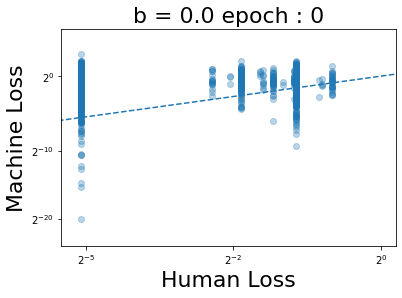

----- epoch: 1 -----
machine_loss: 0.5934696875823041
val_loss: 0.6541728973388672
updated the model


----- epoch: 2 -----
machine_loss: 0.6092407475225627
val_loss: 0.6504151821136475
updated the model


----- epoch: 3 -----
machine_loss: 0.5801791132738193
val_loss: 0.6439638733863831
updated the model


----- epoch: 4 -----
machine_loss: 0.5828968898082773
val_loss: 0.6311889290809631
updated the model


----- epoch: 5 -----
machine_loss: 0.5694639965270957
val_loss: 0.6422382593154907




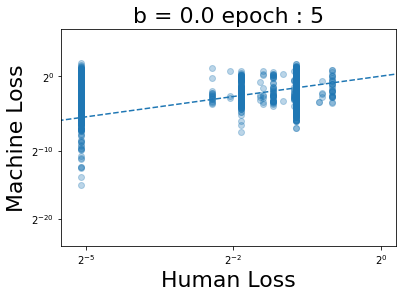

----- epoch: 6 -----
machine_loss: 0.5859624867637953
val_loss: 0.6314157843589783


----- epoch: 7 -----
machine_loss: 0.5924886047529677
val_loss: 0.6542021632194519


----- epoch: 8 -----
machine_loss: 0.5569226893906792
val_loss: 0.6550987958908081


----- epoch: 9 -----
machine_loss: 0.5720438131441673
val_loss: 0.6194390058517456
updated the model


----- epoch: 10 -----
machine_loss: 0.5576150378522774
val_loss: 0.630022406578064




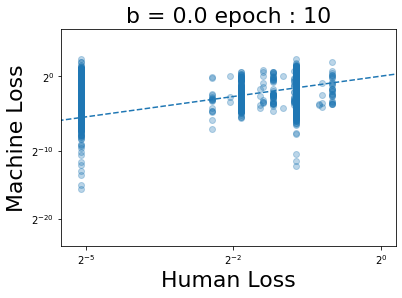

----- epoch: 11 -----
machine_loss: 0.5418380148087939
val_loss: 0.6315373182296753


----- epoch: 12 -----
machine_loss: 0.5688634131414195
val_loss: 0.6235260367393494


----- epoch: 13 -----
machine_loss: 0.5655185288439194
val_loss: 0.6220654249191284


----- epoch: 14 -----
machine_loss: 0.5735161957951883
val_loss: 0.6398241519927979


----- epoch: 15 -----
machine_loss: 0.5497223854375383
val_loss: 0.640729546546936




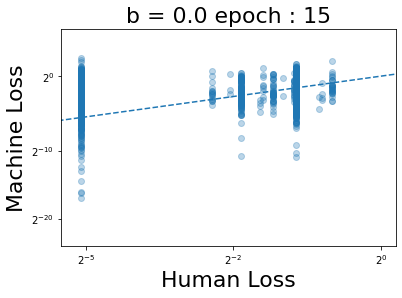

----- epoch: 16 -----
machine_loss: 0.5490988655947149
val_loss: 0.6658611297607422


----- epoch: 17 -----
machine_loss: 0.575624107538412
val_loss: 0.6362775564193726


----- epoch: 18 -----
machine_loss: 0.5392821730735401
val_loss: 0.6186641454696655
updated the model


----- epoch: 19 -----
machine_loss: 0.5657350391459962
val_loss: 0.6122079491615295
updated the model


----- epoch: 20 -----
machine_loss: 0.5498192569551369
val_loss: 0.6226341724395752




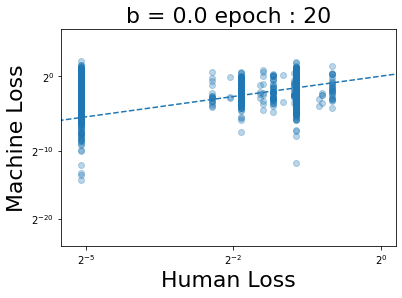

----- epoch: 21 -----
machine_loss: 0.5580560946837068
val_loss: 0.603157103061676
updated the model


----- epoch: 22 -----
machine_loss: 0.5474217201893529
val_loss: 0.5919373631477356
updated the model


----- epoch: 23 -----
machine_loss: 0.5581825195501248
val_loss: 0.5883856415748596
updated the model


----- epoch: 24 -----
machine_loss: 0.5569330300204456
val_loss: 0.5874971747398376
updated the model


----- epoch: 25 -----
machine_loss: 0.5577567845272521
val_loss: 0.5919492244720459




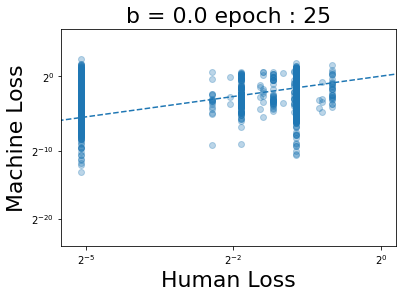

----- epoch: 26 -----
machine_loss: 0.558070108294487
val_loss: 0.5879963040351868


----- epoch: 27 -----
machine_loss: 0.5443513244390488
val_loss: 0.5912847518920898


----- epoch: 28 -----
machine_loss: 0.5564283737912774
val_loss: 0.5782291293144226
updated the model


----- epoch: 29 -----
machine_loss: 0.54000806560119
val_loss: 0.5877277255058289




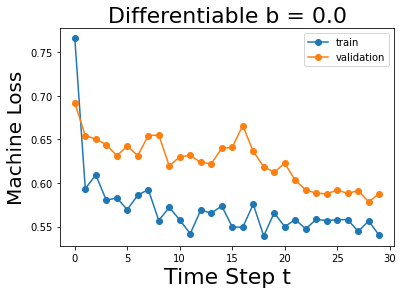

In [82]:
train_triage(data_path,0.0)

training machine model using constraint: 0.2  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.8934049519399802
val_loss: 0.7656171321868896
updated the model




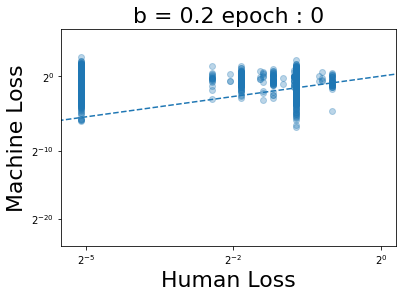

----- epoch: 1 -----
machine_loss: 0.30633069667965174
val_loss: 0.422407865524292
updated the model


----- epoch: 2 -----
machine_loss: 0.18188463950840136
val_loss: 0.10608194768428802
updated the model


----- epoch: 3 -----
machine_loss: 0.14880439712821195
val_loss: 0.11034995317459106


----- epoch: 4 -----
machine_loss: 0.1330429450996841
val_loss: 0.10032735019922256
updated the model


----- epoch: 5 -----
machine_loss: 0.13939247117377818
val_loss: 0.06707961857318878
updated the model




<ipython-input-158-9d529f35780f>:100: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


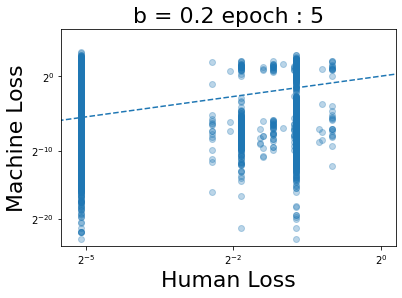

----- epoch: 6 -----
machine_loss: 0.11618950117068987
val_loss: 0.09412156045436859


----- epoch: 7 -----
machine_loss: 0.12380951945669949
val_loss: 0.07092280685901642


----- epoch: 8 -----
machine_loss: 0.05221882994131496
val_loss: 0.15698640048503876


----- epoch: 9 -----
machine_loss: 0.01342805017096301
val_loss: 0.13876210153102875


----- epoch: 10 -----
machine_loss: 0.03332875564228743
val_loss: 0.09800351411104202




<ipython-input-158-9d529f35780f>:100: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


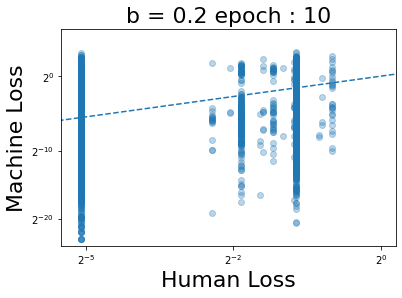

----- epoch: 11 -----
machine_loss: 0.051790314610116184
val_loss: 0.08017187565565109


----- epoch: 12 -----
machine_loss: 0.06876995523149769
val_loss: 0.10474418848752975


----- epoch: 13 -----
machine_loss: 0.04564821797733506
val_loss: 0.1134316623210907


----- epoch: 14 -----
machine_loss: 0.029344288632273674
val_loss: 0.15317177772521973


----- epoch: 15 -----
machine_loss: 0.04625763806204001
val_loss: 0.1129504144191742




<ipython-input-158-9d529f35780f>:100: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


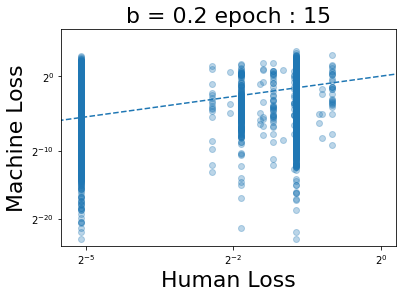

----- epoch: 16 -----
machine_loss: 0.04028456840508928
val_loss: 0.16789990663528442
no progress for 10 epochs... stopping training


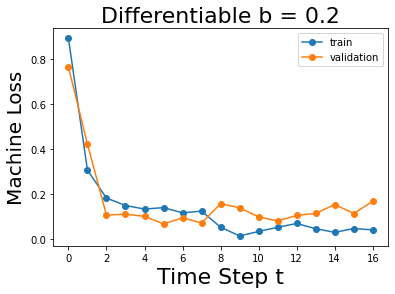

In [159]:
train_triage(data_path,0.2)

training machine model using constraint: 0.4  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.49725045267647755
val_loss: 0.4789806604385376
updated the model




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


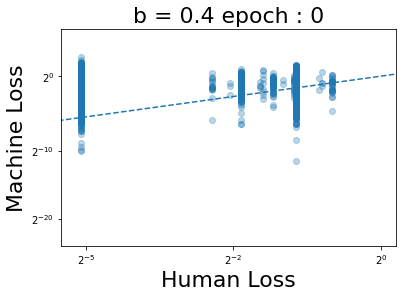

----- epoch: 1 -----
machine_loss: 0.0721042353300921
val_loss: 0.04621989279985428
updated the model


----- epoch: 2 -----
machine_loss: 0.012111483416750465
val_loss: 0.009005358442664146
updated the model


----- epoch: 3 -----
machine_loss: 0.01053266652019147
val_loss: 0.0038805000949651003
updated the model


----- epoch: 4 -----
machine_loss: 0.011258368544076802
val_loss: 0.0040116943418979645


----- epoch: 5 -----
machine_loss: 0.007621763639709418
val_loss: 0.01288356352597475




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


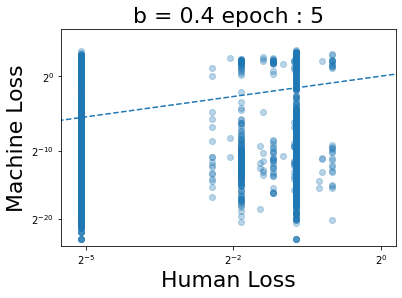

----- epoch: 6 -----
machine_loss: 0.01515926368330156
val_loss: 0.014121737331151962


----- epoch: 7 -----
machine_loss: 0.012306929724689534
val_loss: 0.020922066643834114


----- epoch: 8 -----
machine_loss: 0.013731405394897441
val_loss: 0.012642589397728443


----- epoch: 9 -----
machine_loss: 0.01198859377112882
val_loss: 0.007462570443749428


----- epoch: 10 -----
machine_loss: 0.023959925105807283
val_loss: 0.008012153208255768




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


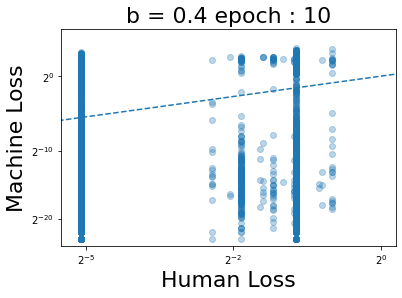

----- epoch: 11 -----
machine_loss: 0.012508440584947303
val_loss: 0.00810181349515915


----- epoch: 12 -----
machine_loss: 0.01904921730508106
val_loss: 0.006071360781788826


----- epoch: 13 -----
machine_loss: 0.009857511589367837
val_loss: 0.01367434673011303


----- epoch: 14 -----
machine_loss: 0.01366334508894577
val_loss: 0.011813472956418991
no progress for 10 epochs... stopping training


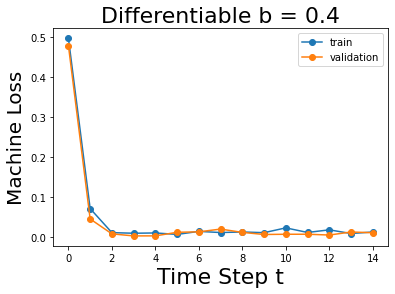

In [124]:
train_triage(data_path,0.4)

training machine model using constraint: 0.6  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.062455737083970085
val_loss: 0.05306721106171608
updated the model




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


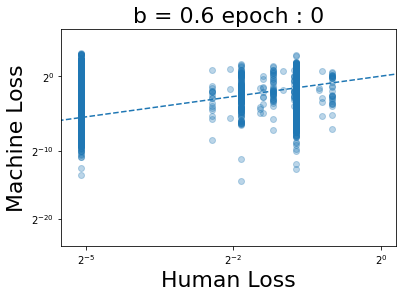

----- epoch: 1 -----
machine_loss: 0.00014924789252290793
val_loss: 7.617660594405606e-05
updated the model


----- epoch: 2 -----
machine_loss: 5.676181751823606e-05
val_loss: 3.949674282921478e-05


----- epoch: 3 -----
machine_loss: 3.103554247019247e-05
val_loss: 2.3648128262721002e-05


----- epoch: 4 -----
machine_loss: 2.0746501070571337e-05
val_loss: 1.7449894585297443e-05


----- epoch: 5 -----
machine_loss: 1.5647367835214254e-05
val_loss: 1.1772377547458746e-05




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


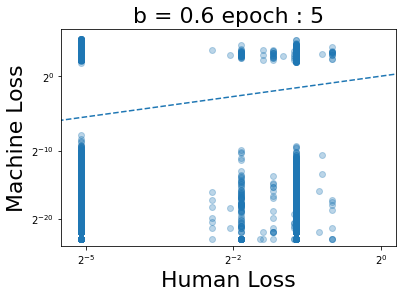

----- epoch: 6 -----
machine_loss: 1.179526390338026e-05
val_loss: 9.531754585623275e-06


----- epoch: 7 -----
machine_loss: 9.464569309021916e-06
val_loss: 7.426623596984427e-06


----- epoch: 8 -----
machine_loss: 7.633195835114273e-06
val_loss: 7.009756700426806e-06


----- epoch: 9 -----
machine_loss: 6.367495635058636e-06
val_loss: 5.085106749902479e-06


----- epoch: 10 -----
machine_loss: 5.002550163594559e-06
val_loss: 4.081863608007552e-06




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


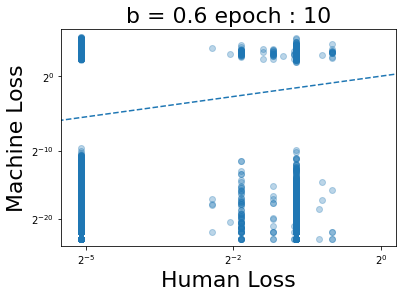

----- epoch: 11 -----
machine_loss: 4.534074108016502e-06
val_loss: 3.785271701417514e-06


----- epoch: 12 -----
machine_loss: 3.6000731829706942e-06
val_loss: 3.5757723253482254e-06
no progress for 10 epochs... stopping training


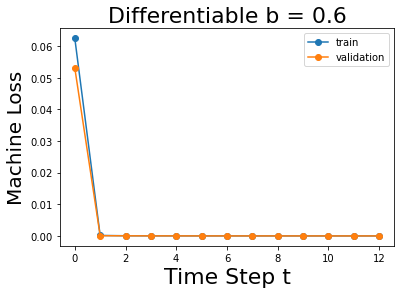

In [125]:
train_triage(data_path,0.6)

training machine model using constraint: 0.8  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 1.271372198748092
val_loss: 1.3609181642532349
updated the model




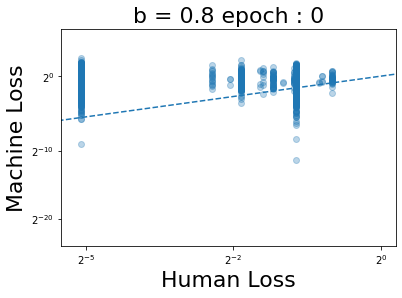

----- epoch: 1 -----
machine_loss: 1.0430402810064454
val_loss: 0.9376701712608337
updated the model


----- epoch: 2 -----
machine_loss: 0.32156267047200043
val_loss: 0.2593713104724884
updated the model


----- epoch: 3 -----
machine_loss: 0.05974942857331674
val_loss: 0.15653067827224731
updated the model


----- epoch: 4 -----
machine_loss: 0.0755990431898681
val_loss: 0.051115795969963074
updated the model


----- epoch: 5 -----
machine_loss: 0.0223718116173283
val_loss: 0.026350896805524826
updated the model




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


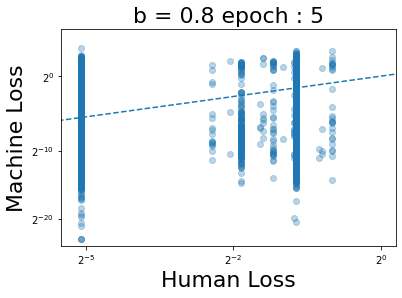

----- epoch: 6 -----
machine_loss: 0.01544628140148537
val_loss: 0.0269935242831707


----- epoch: 7 -----
machine_loss: 0.016353113455200703
val_loss: 0.02569023333489895
updated the model


----- epoch: 8 -----
machine_loss: 0.009329752780364705
val_loss: 0.012633740901947021
updated the model


----- epoch: 9 -----
machine_loss: 0.015197295208205711
val_loss: 0.016389252617955208


----- epoch: 10 -----
machine_loss: 0.010319533780394371
val_loss: 0.028818560764193535




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


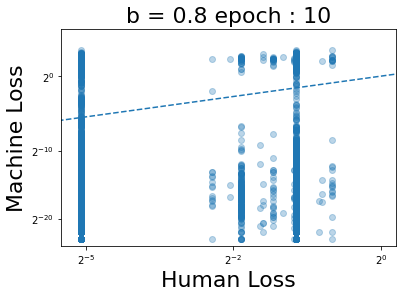

----- epoch: 11 -----
machine_loss: 0.01755658969139991
val_loss: 0.015056594274938107


----- epoch: 12 -----
machine_loss: 0.019463034602660894
val_loss: 0.018767068162560463


----- epoch: 13 -----
machine_loss: 0.01641897233812036
val_loss: 0.02289360761642456


----- epoch: 14 -----
machine_loss: 0.017421269343256718
val_loss: 0.008758004754781723
updated the model


----- epoch: 15 -----
machine_loss: 0.015344353776075792
val_loss: 0.008416812866926193
updated the model




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


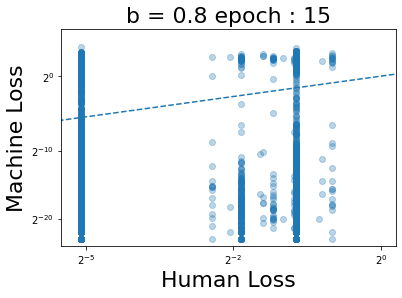

----- epoch: 16 -----
machine_loss: 0.01728355538782485
val_loss: 0.019994761794805527


----- epoch: 17 -----
machine_loss: 0.0193659018421819
val_loss: 0.01400303840637207


----- epoch: 18 -----
machine_loss: 0.025505604996811353
val_loss: 0.0172855406999588


----- epoch: 19 -----
machine_loss: 0.023991186484037048
val_loss: 0.02746347337961197


----- epoch: 20 -----
machine_loss: 0.020699935804595764
val_loss: 0.03157709166407585




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


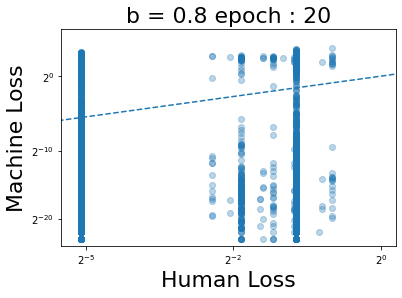

----- epoch: 21 -----
machine_loss: 0.015751541510575933
val_loss: 0.012605763971805573


----- epoch: 22 -----
machine_loss: 0.03140690835093688
val_loss: 0.01936160773038864


----- epoch: 23 -----
machine_loss: 0.014388758872026841
val_loss: 0.03237757459282875


----- epoch: 24 -----
machine_loss: 0.022847580253788635
val_loss: 0.06729539483785629


----- epoch: 25 -----
machine_loss: 0.0103028252225279
val_loss: 0.0086257578805089




<ipython-input-121-59023a7cd6fa>:97: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)


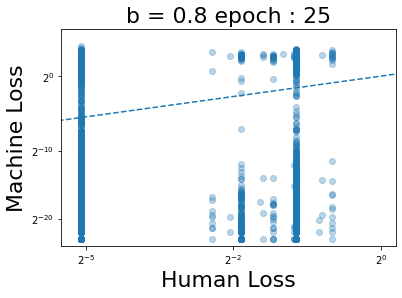

----- epoch: 26 -----
machine_loss: 0.014661953194216851
val_loss: 0.020334845408797264
no progress for 10 epochs... stopping training


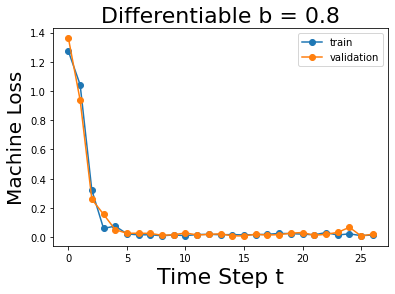

In [126]:
train_triage(data_path,0.8)

training machine model using constraint: 1.0  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.10607573172698419
val_loss: 1.2056244611740112
updated the model




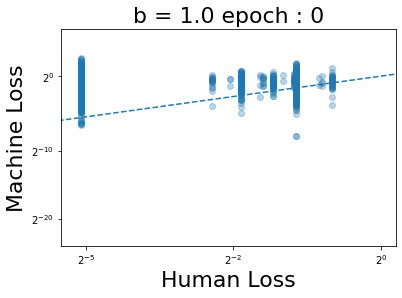

----- epoch: 1 -----
machine_loss: 0.009568301339944204
val_loss: 0.8081892132759094
updated the model


----- epoch: 2 -----
machine_loss: 0.006014420961340268
val_loss: 0.710599422454834
updated the model


----- epoch: 3 -----
machine_loss: 0.0
val_loss: 0.6862230896949768
updated the model


----- epoch: 4 -----
machine_loss: 0.0
val_loss: 0.6555208563804626
updated the model


----- epoch: 5 -----
machine_loss: 0.0
val_loss: 0.6570412516593933




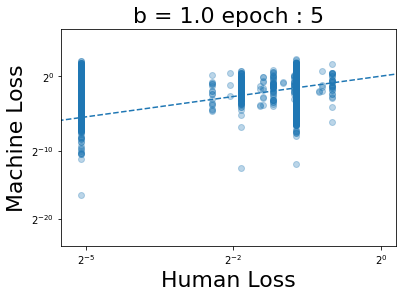

----- epoch: 6 -----
machine_loss: 0.0
val_loss: 0.6497966051101685
updated the model


----- epoch: 7 -----
machine_loss: 0.0
val_loss: 0.6641520857810974


----- epoch: 8 -----
machine_loss: 0.0
val_loss: 0.6282749772071838
updated the model


----- epoch: 9 -----
machine_loss: 0.0
val_loss: 0.6721639037132263


----- epoch: 10 -----
machine_loss: 0.0
val_loss: 0.6221786141395569
updated the model




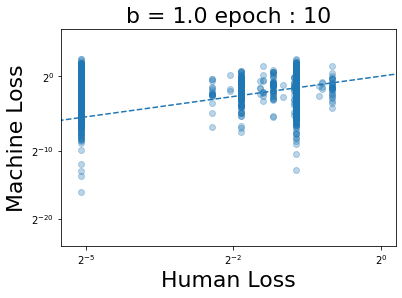

----- epoch: 11 -----
machine_loss: 0.0
val_loss: 0.6427176594734192


----- epoch: 12 -----
machine_loss: 0.0
val_loss: 0.6635046601295471


----- epoch: 13 -----
machine_loss: 0.0
val_loss: 0.6392511129379272


----- epoch: 14 -----
machine_loss: 0.0
val_loss: 0.6082140803337097
updated the model


----- epoch: 15 -----
machine_loss: 0.0
val_loss: 0.6291302442550659




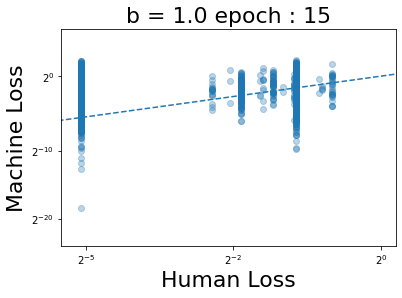

----- epoch: 16 -----
machine_loss: 0.004093708470463753
val_loss: 0.5154567360877991
updated the model


----- epoch: 17 -----
machine_loss: 0.0
val_loss: 0.45963454246520996
updated the model


----- epoch: 18 -----
machine_loss: 0.0
val_loss: 0.4599665105342865


----- epoch: 19 -----
machine_loss: 0.0
val_loss: 0.4474686086177826
updated the model


----- epoch: 20 -----
machine_loss: 0.0
val_loss: 0.4729935824871063




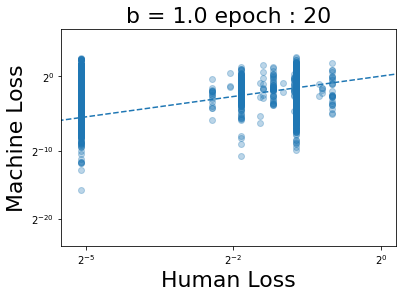

----- epoch: 21 -----
machine_loss: 0.0
val_loss: 0.46421462297439575


----- epoch: 22 -----
machine_loss: 0.0
val_loss: 0.43762531876564026
updated the model


----- epoch: 23 -----
machine_loss: 0.0
val_loss: 0.45704737305641174


----- epoch: 24 -----
machine_loss: 0.0
val_loss: 0.4439948499202728


----- epoch: 25 -----
machine_loss: 0.0
val_loss: 0.4681858718395233




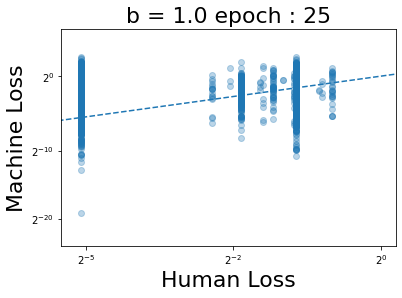

----- epoch: 26 -----
machine_loss: 0.0
val_loss: 0.474575012922287


----- epoch: 27 -----
machine_loss: 0.0
val_loss: 0.47476089000701904


----- epoch: 28 -----
machine_loss: 0.0
val_loss: 0.4771939516067505


----- epoch: 29 -----
machine_loss: 0.0
val_loss: 0.4673001766204834




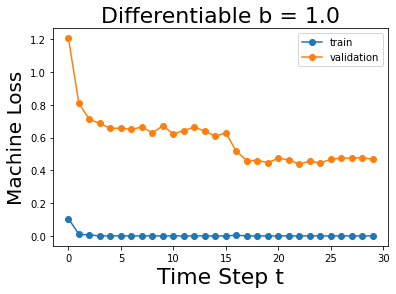

In [129]:
train_triage(data_path,1.0)

#### We train the additional model g to approximate difference of machine loss and human loss for unseen samples. The same CNN and the same training procedure is used for training g. Please refer to 

In [84]:
def train_g(data_path, machine_type,constraint):
    print('started training g using the constraint: ',constraint,' Using machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(copy.deepcopy(data['X'])).float().to(device)
    Y = torch.from_numpy(copy.deepcopy(data['Y'])).long().to(device)
    hloss = data['hloss'].to(device)
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
    if machine_type == 'full':
        mnet.load_state_dict(torch.load(model_dir + 'm_full'))
        
    else:
        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        
    mnet.eval()
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 50
    
    gnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)
    
#     lr=0.008
#     if constraint==0.6:
    lr = 0.0002
    g_optimizer = torch.optim.Adam(gnet.parameters(),lr=lr)
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    cnt = 0
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)
            g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
            g_optimizer.zero_grad()
            g_loss = loss_func(gnet(X_batch),g_labels)
            g_loss.sum().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
        
        with torch.no_grad():
            val_machine_loss = loss_func(mnet(val_X),val_Y)
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X.shape[0])]).to(device)
            val_loss = loss_func(gnet(val_X),val_glabels)
            val_gloss = float(val_loss.mean())
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))
            
            if val_gloss + eps < best_val_loss:
                torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type + str(constraint))
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
                
            else:
                patience += 1
            
        if patience > max_patience:
            gnet.load_state_dict(torch.load(model_dir + 'g_' + machine_type + str(constraint)))
            patience = 0
            cnt += 1
            
        if cnt>10:
            print('no progress for 10 epochs... stopping training')
            break

                
        print('\n')
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g using b = ' + str(constraint),fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()
        

started training g using the constraint:  0.0  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.10303951000484328
val_g_loss: 0.01737944781780243
updated the model


----- epoch: 1 -----
g_loss: 0.07357823615893722
val_g_loss: 0.01868657022714615


----- epoch: 2 -----
g_loss: 0.0685203781273837
val_g_loss: 0.019055822864174843


----- epoch: 3 -----
g_loss: 0.06372146496626858
val_g_loss: 0.01704181358218193
updated the model


----- epoch: 4 -----
g_loss: 0.06307391383840392
val_g_loss: 0.016983654350042343


----- epoch: 5 -----
g_loss: 0.06181994670381149
val_g_loss: 0.015284690074622631
updated the model


----- epoch: 6 -----
g_loss: 0.05551324802218005
val_g_loss: 0.013988195918500423
updated the model


----- epoch: 7 -----
g_loss: 0.05443026059462378
val_g_loss: 0.013501069508492947
updated the model


----- epoch: 8 -----
g_loss: 0.05199812296389913
val_g_loss: 0.013096570037305355
updated the model


----- epoch: 9 -----
g_loss: 0.05323190527269617
val_g_l

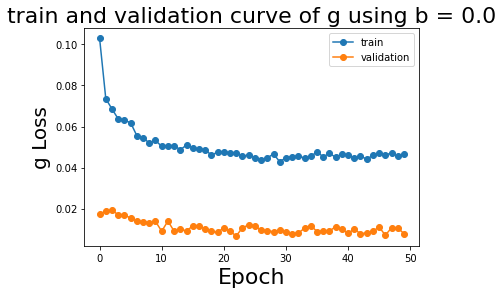

In [85]:
train_g(data_path,'Differentiable',0.0)

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6024528058866659
val_g_loss: 0.5895856618881226
updated the model


----- epoch: 1 -----
g_loss: 0.5650363036741813
val_g_loss: 0.5592032074928284
updated the model


----- epoch: 2 -----
g_loss: 0.5456466634447376
val_g_loss: 0.5382187962532043
updated the model


----- epoch: 3 -----
g_loss: 0.521635029775401
val_g_loss: 0.5251780152320862
updated the model


----- epoch: 4 -----
g_loss: 0.5132536711171269
val_g_loss: 0.5245692729949951
updated the model


----- epoch: 5 -----
g_loss: 0.5100209284573793
val_g_loss: 0.5101292729377747
updated the model


----- epoch: 6 -----
g_loss: 0.5006704690555731
val_g_loss: 0.5136240124702454


----- epoch: 7 -----
g_loss: 0.4980767099186778
val_g_loss: 0.5034148693084717
updated the model


----- epoch: 8 -----
g_loss: 0.49139933846890926
val_g_loss: 0.5080007910728455


----- epoch: 9 -----
g_loss: 0.49345913870881003
val_g_loss: 

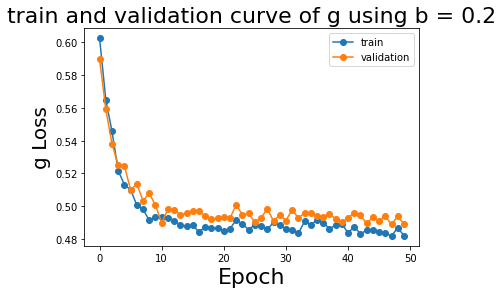

In [235]:
train_g(data_path,'Differentiable',0.2)

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6161503711094459
val_g_loss: 0.5445970892906189
updated the model


----- epoch: 1 -----
g_loss: 0.546909699216485
val_g_loss: 0.5327408909797668
updated the model


----- epoch: 2 -----
g_loss: 0.5402091272796193
val_g_loss: 0.5572069883346558


----- epoch: 3 -----
g_loss: 0.5238834107294679
val_g_loss: 0.5200751423835754
updated the model


----- epoch: 4 -----
g_loss: 0.5257140963027874
val_g_loss: 0.5354177355766296


----- epoch: 5 -----
g_loss: 0.5255691126609842
val_g_loss: 0.5125555992126465
updated the model


----- epoch: 6 -----
g_loss: 0.5159400866056482
val_g_loss: 0.5228232145309448


----- epoch: 7 -----
g_loss: 0.5166832441464067
val_g_loss: 0.4900575876235962
updated the model


----- epoch: 8 -----
g_loss: 0.5111314024155339
val_g_loss: 0.5388774275779724


----- epoch: 9 -----
g_loss: 0.5039093090842167
val_g_loss: 0.5251755714416504


----- epoch: 10 -

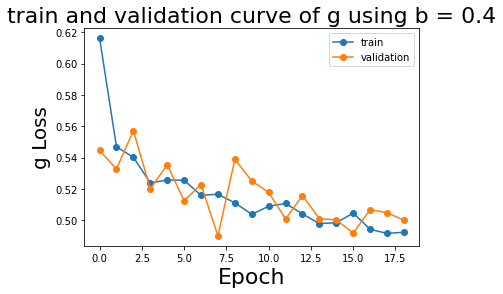

In [170]:
train_g(data_path,'Differentiable',0.4)

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6327576438585917
val_g_loss: 0.6025365591049194
updated the model


----- epoch: 1 -----
g_loss: 0.5834440849721432
val_g_loss: 0.5617223978042603
updated the model


----- epoch: 2 -----
g_loss: 0.5572114307433367
val_g_loss: 0.5476185083389282
updated the model


----- epoch: 3 -----
g_loss: 0.5487969278668364
val_g_loss: 0.5298143625259399
updated the model


----- epoch: 4 -----
g_loss: 0.5327388731141885
val_g_loss: 0.5229225158691406
updated the model


----- epoch: 5 -----
g_loss: 0.5210706427072486
val_g_loss: 0.5241001844406128


----- epoch: 6 -----
g_loss: 0.5234723507116238
val_g_loss: 0.5145893096923828
updated the model


----- epoch: 7 -----
g_loss: 0.5153793198987842
val_g_loss: 0.5123959183692932
updated the model


----- epoch: 8 -----
g_loss: 0.5094484227399031
val_g_loss: 0.5034112334251404
updated the model


----- epoch: 9 -----
g_loss: 0.507010822494

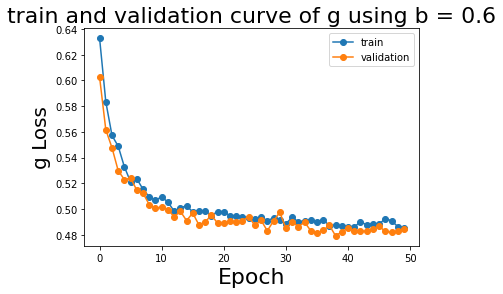

In [234]:
train_g(data_path,'Differentiable',0.6)

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6400601230561733
val_g_loss: 0.5920509099960327
updated the model


----- epoch: 1 -----
g_loss: 0.5729069863446057
val_g_loss: 0.5489222407341003
updated the model


----- epoch: 2 -----
g_loss: 0.553605591567854
val_g_loss: 0.5542672872543335


----- epoch: 3 -----
g_loss: 0.5437185750342906
val_g_loss: 0.5278725028038025
updated the model


----- epoch: 4 -----
g_loss: 0.5310579741684099
val_g_loss: 0.5312967300415039


----- epoch: 5 -----
g_loss: 0.5257843034341931
val_g_loss: 0.5124801397323608
updated the model


----- epoch: 6 -----
g_loss: 0.5241411249153316
val_g_loss: 0.5161098837852478


----- epoch: 7 -----
g_loss: 0.5178222454463443
val_g_loss: 0.5089318752288818
updated the model


----- epoch: 8 -----
g_loss: 0.5181154506281018
val_g_loss: 0.5118067860603333


----- epoch: 9 -----
g_loss: 0.5120164571950833
val_g_loss: 0.5071409344673157
updated the model



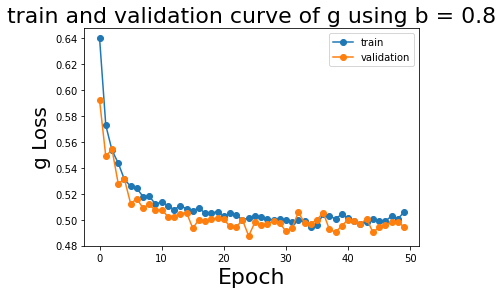

In [229]:
train_g(data_path,'Differentiable',0.8)

started training g using the constraint:  1.0  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.5732611050674071
val_g_loss: 0.5580347776412964
updated the model


----- epoch: 1 -----
g_loss: 0.5447410168126225
val_g_loss: 0.5425007343292236
updated the model


----- epoch: 2 -----
g_loss: 0.5155259550859531
val_g_loss: 0.5222864747047424
updated the model


----- epoch: 3 -----
g_loss: 0.5091020294154683
val_g_loss: 0.5168306827545166
updated the model


----- epoch: 4 -----
g_loss: 0.5034930600474278
val_g_loss: 0.5102056860923767
updated the model


----- epoch: 5 -----
g_loss: 0.49485465775554377
val_g_loss: 0.50517338514328
updated the model


----- epoch: 6 -----
g_loss: 0.4932436974098285
val_g_loss: 0.49850842356681824
updated the model


----- epoch: 7 -----
g_loss: 0.4926688689738512
val_g_loss: 0.5014948844909668


----- epoch: 8 -----
g_loss: 0.4857788585747282
val_g_loss: 0.4929541349411011
updated the model


----- epoch: 9 -----
g_loss: 0.486535871711

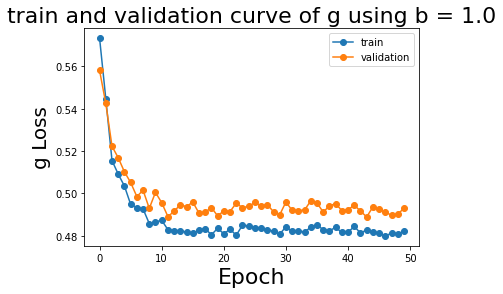

In [230]:
train_g(data_path,'Differentiable',1.0)

In [61]:
def get_test_assignments_us(data_path,constraints):
    machine_type = 'Differentiable'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    losses = []
    for constraint in constraints:
        loss = np.zeros(test_X.shape[0])
        num_machine = int((1.0 - constraint) * test_X.shape[0])
        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_Differentiable' + str(constraint)))
        mnet.eval()
        
        mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
        
        gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)

        gnet.load_state_dict(torch.load(model_dir + 'g_Differentiable' + str(constraint)))
        gnet.eval()
        
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        to_machine = torch.argsort(gprediction)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
        
        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)
        
        if to_machine.shape[0]!=0:
            loss[to_machine] = mloss[to_machine]
        if len(to_human)!=0:
            loss[to_human] = hloss[to_human]

        losses.append(np.mean(loss))
        del mnet
        del gnet
    
    plt.plot(constraints,losses,marker='o')
    plt.xticks(constraints)
    plt.title(r'our method',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data.keys():
        data[machine_type] = {}
    
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)

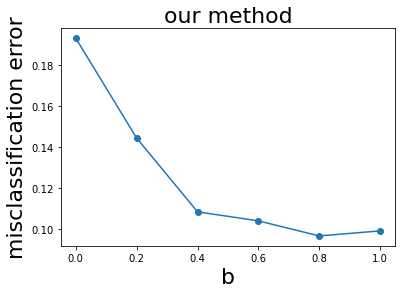

In [86]:
get_test_assignments_us(data_path,constraints)

In [297]:
def boxplot():
    constraints = [0.4, 0.6, 0.8, 1.0]
    res = load_data('results/Differentiable')
    for constraint in constraints:
        fig, ax = plt.subplots()

        gpred = res[constraint]['gprediction'].cpu()
        mloss = res[constraint]['mcrossloss'].cpu()
        hloss = res[constraint]['hcrossloss'].cpu()
        to_machine = res[constraint]['to_machine']
        to_human = res[constraint]['to_human']
        threshold_map = {0.0: 0.0, 0.2: 0.257, 0.4: 0.257, 0.6: 0.211, 0.8: 0.211, 1.0: 0.373}
        below = [idx for idx in range(gpred.shape[0]) if idx in to_machine]
        above = [idx for idx in range(gpred.shape[0]) if idx in to_human]
        below_data = [np.log2(mloss[idx]) - np.log2(hloss[idx]) for idx in below]
        above_data = [np.log2(mloss[idx]) - np.log2(hloss[idx]) for idx in above]
        
        medianprops = dict(linestyle='-.', linewidth=2.5, color='black')

        ax1 = ax.boxplot(np.array(below_data), positions=[0],  widths=0.35,sym='',whis=0,medianprops=medianprops,#usermedians=[np.mean(below_data)],
                         patch_artist=True, boxprops=dict(facecolor="C0"))
        ax2 = ax.boxplot(np.array(above_data), positions=[1],  widths=0.35,sym='',whis=0,medianprops = medianprops,#usermedians=[np.mean(above_data)],
                         patch_artist=True, boxprops=dict(facecolor="C1"))
        plt.show()

/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


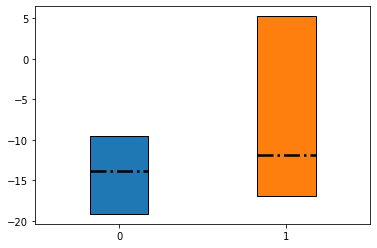

/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


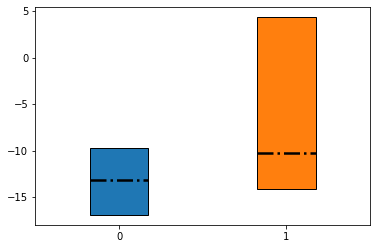

/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/nastaran/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/home/nastaran/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


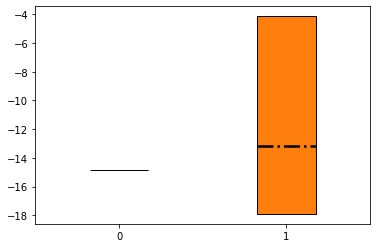

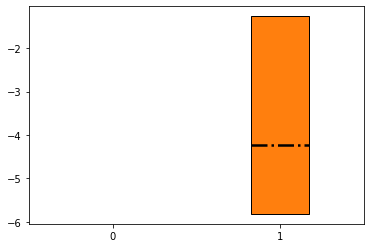

In [298]:
boxplot()

# Baselines

## [Confidence Based Triage](https://arxiv.org/abs/2004.13102)

In [115]:
def train_confidence(data_path,constraint):
    machine_type = 'confidence'
    print('-----training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
        
    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.001)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hconf_batch = hconf[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_conf_batch, _ = torch.max(machine_scores_batch,axis = 1)   
            machine_indices = find_machine_samples(hconf_batch,machine_conf_batch,constraint)
            
                
                
            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            
            if torch.unique(Y_machine).shape[0]<3:
                continue
            
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_conf,_ = torch.max(val_machine_scores,axis=1)

            val_machine_indices = find_machine_samples(val_hconf,val_machine_conf,constraint)

            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            
            val_losses.append(val_loss)
            print('val_loss:',val_loss) 
            
            if val_loss + eps <best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
      
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model using constraint: 0.0  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.8091997802257538
val_loss: 0.7551228404045105
updated the model


----- epoch: 1 -----
machine_loss: 0.7472762676576773
val_loss: 0.7176083922386169
updated the model


----- epoch: 2 -----
machine_loss: 0.7193078901618719
val_loss: 0.692796528339386
updated the model


----- epoch: 3 -----
machine_loss: 0.7000475594153007
val_loss: 0.6643425822257996
updated the model


----- epoch: 4 -----
machine_loss: 0.6827970705926418
val_loss: 0.661366879940033
updated the model


----- epoch: 5 -----
machine_loss: 0.6680756754552325
val_loss: 0.6595519185066223
updated the model


----- epoch: 6 -----
machine_loss: 0.6644364905854067
val_loss: 0.6419973969459534
updated the model


----- epoch: 7 -----
machine_loss: 0.656257708867391
val_loss: 0.6418923139572144
updated the model


----- epoch: 8 -----
machine_loss: 0.6458989875391126
val_loss: 0.6256592869758606
updated the mo

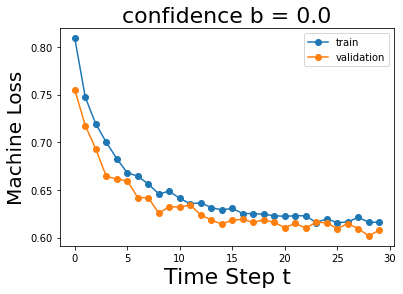

In [93]:
train_confidence(data_path,0.0)

-----training machine model using constraint: 0.2  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 1.1967467044790585
val_loss: 0.7535565495491028
updated the model


----- epoch: 1 -----
machine_loss: 0.6501006620625654
val_loss: 0.6544632911682129
updated the model


----- epoch: 2 -----
machine_loss: 0.626582682132721
val_loss: 0.6807940006256104


----- epoch: 3 -----
machine_loss: 0.6391925007725755
val_loss: 0.6249483227729797
updated the model


----- epoch: 4 -----
machine_loss: 0.6080121444538236
val_loss: 0.8006810545921326


----- epoch: 5 -----
machine_loss: 0.6553619668508569
val_loss: 0.6986750960350037


----- epoch: 6 -----
machine_loss: 0.5957792056724429
val_loss: 0.5804871916770935
updated the model


----- epoch: 7 -----
machine_loss: 0.5590867583329479
val_loss: 0.5850273370742798


----- epoch: 8 -----
machine_loss: 0.5884681837633252
val_loss: 0.566193699836731
updated the model


----- epoch: 9 -----
machine_loss: 0.5425560312966505
val_loss: 0

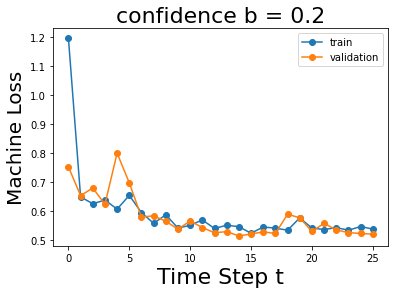

In [39]:
train_confidence(data_path,0.2)

-----training machine model using constraint: 0.4  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 1.1697843568399549
val_loss: 0.9903842210769653
updated the model


----- epoch: 1 -----
machine_loss: 0.7004159061859051
val_loss: 0.7205204963684082
updated the model


----- epoch: 2 -----
machine_loss: 0.6334517343590657
val_loss: 0.7355825304985046


----- epoch: 3 -----
machine_loss: 0.6572289690375328
val_loss: 0.6703395843505859
updated the model


----- epoch: 4 -----
machine_loss: 0.6168054090812802
val_loss: 0.5634190440177917
updated the model


----- epoch: 5 -----
machine_loss: 0.5592134601126114
val_loss: 0.5332971811294556
updated the model


----- epoch: 6 -----
machine_loss: 0.5661228069414695
val_loss: 0.5472317934036255


----- epoch: 7 -----
machine_loss: 0.5047305425008138
val_loss: 0.5018202066421509
updated the model


----- epoch: 8 -----
machine_loss: 0.5270560455198089
val_loss: 0.5306292772293091


----- epoch: 9 -----
machine_loss: 0.52826897

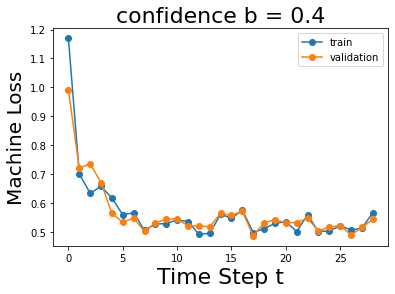

In [40]:
train_confidence(data_path,0.4)

-----training machine model using constraint: 0.6  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 1.1776104308664799
val_loss: 0.7865800261497498
updated the model


----- epoch: 1 -----
machine_loss: 0.6861046934500337
val_loss: 0.6449383497238159
updated the model


----- epoch: 2 -----
machine_loss: 0.670742736508449
val_loss: 0.6825326681137085


----- epoch: 3 -----
machine_loss: 0.5735032741601268
val_loss: 0.5741612315177917
updated the model


----- epoch: 4 -----
machine_loss: 0.5921194823458791
val_loss: 0.5440807342529297
updated the model


----- epoch: 5 -----
machine_loss: 0.5556616994241873
val_loss: 0.6220141053199768


----- epoch: 6 -----
machine_loss: 0.5140498401597142
val_loss: 0.5173634886741638
updated the model


----- epoch: 7 -----
machine_loss: 0.5817928689842423
val_loss: 0.5452209711074829


----- epoch: 8 -----
machine_loss: 0.530702111000816
val_loss: 0.5809121131896973


----- epoch: 9 -----
machine_loss: 0.6330865925798813
val_loss: 0

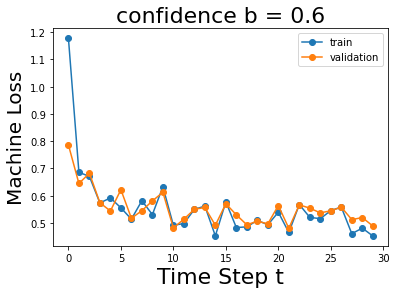

In [41]:
train_confidence(data_path,0.6)

-----training machine model using constraint: 0.8  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 1.3674782058224082
val_loss: 0.9873549342155457
updated the model


----- epoch: 1 -----
machine_loss: 0.755466657380263
val_loss: 0.6412140727043152
updated the model


----- epoch: 2 -----
machine_loss: 0.6800138875842094
val_loss: 0.7499304413795471


----- epoch: 3 -----
machine_loss: 0.6365603863572081
val_loss: 0.6668264269828796


----- epoch: 4 -----
machine_loss: 0.6435603024438024
val_loss: 0.7186065912246704


----- epoch: 5 -----
machine_loss: 0.6318864086642861
val_loss: 0.6700730919837952


----- epoch: 6 -----
machine_loss: 0.4209791539857785
val_loss: 0.5474491119384766
updated the model


----- epoch: 7 -----
machine_loss: 0.44074162809799117
val_loss: 0.545221745967865
updated the model


----- epoch: 8 -----
machine_loss: 0.5695794771114985
val_loss: 0.5710948705673218


----- epoch: 9 -----
machine_loss: 0.5857899393886328
val_loss: 0.5680092573165894

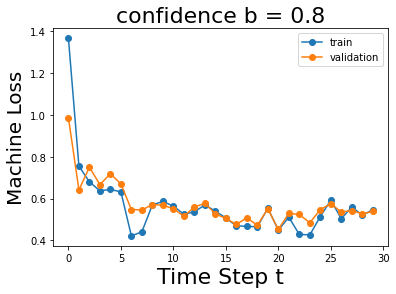

In [49]:
train_confidence(data_path,0.8)

-----training machine model using constraint: 1.0  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.4419390515734752
val_loss: 1.1468801498413086
updated the model


----- epoch: 1 -----
machine_loss: 0.8086669705808163
val_loss: 0.7230128645896912
updated the model


----- epoch: 2 -----
machine_loss: 0.6494825513412555
val_loss: 0.6347619891166687
updated the model


----- epoch: 3 -----
machine_loss: 0.5994544671848416
val_loss: 0.6189562082290649
updated the model


----- epoch: 4 -----
machine_loss: 0.5544046567132076
val_loss: 0.6002565622329712
updated the model


----- epoch: 5 -----
machine_loss: 0.5628604373584191
val_loss: 0.5832837820053101
updated the model


----- epoch: 6 -----
machine_loss: 0.5631829105938474
val_loss: 0.5330105423927307
updated the model


----- epoch: 7 -----
machine_loss: 0.6199955490107337
val_loss: 0.607036292552948


----- epoch: 8 -----
machine_loss: 0.6040712657074133
val_loss: 0.5785504579544067


----- epoch: 9 -----
machine

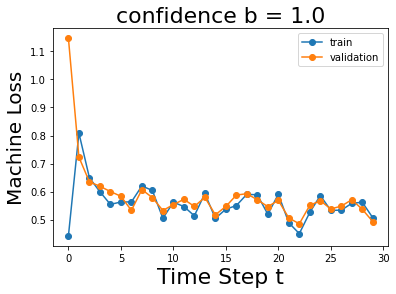

In [116]:
train_confidence(data_path,1.0)

In [106]:
def get_test_assignments_confidence(data_path,constraints):
    machine_type = 'confidence'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    hconf = (torch.mean(data['hprob']) + torch.zeros(test_X.shape[0])).to(device)
    
    losses = []
    for constraint in constraints:
        if constraint==0.0:
                losses.append(data['Differentiable']['agg_loss'][0])
                continue
        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_' + machine_type + str(constraint)))
        mnet.eval()
        mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
        loss = np.zeros(test_X.shape[0])
        mconf,_ = torch.max(mnet(test_X),axis = 1)
        to_machine = find_machine_samples(hconf,mconf,constraint).cpu().data.numpy()

        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        del mnet
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Confidence-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data.keys():
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    
    save_data(data,data_path)

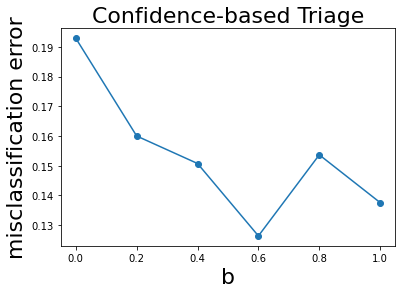

In [117]:
get_test_assignments_confidence(data_path,constraints)

## Full Automation Triage
The machine model is trained under full automation and then an additional model g is trained based on the difference of machine and human loss and used to outsource samples at test time.

In [291]:
def train_full(data_path, machine_type):
    print('-----training machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0]/batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.005)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),Y_batch)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = float(loss_func(mnet(val_X),val_Y).mean())
            print('val_loss:',val_loss)
            val_losses.append(val_loss)
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
    
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    plt.legend()
    plt.title(machine_type, fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()
        

-----training machine model:  full
----- epoch: 0 -----
machine_loss: 0.8031298510419825
val_loss: 0.7341479063034058
updated the model


----- epoch: 1 -----
machine_loss: 0.719657179278632
val_loss: 0.6831042766571045
updated the model


----- epoch: 2 -----
machine_loss: 0.6891141581969956
val_loss: 0.6796451807022095
updated the model


----- epoch: 3 -----
machine_loss: 0.6811873416105906
val_loss: 0.6613176465034485
updated the model


----- epoch: 4 -----
machine_loss: 0.6637021532903115
val_loss: 0.6477273106575012
updated the model


----- epoch: 5 -----
machine_loss: 0.6591774777819713
val_loss: 0.6456629633903503
updated the model


----- epoch: 6 -----
machine_loss: 0.6430468014441431
val_loss: 0.6319553852081299
updated the model


----- epoch: 7 -----
machine_loss: 0.6482227820282181
val_loss: 0.6342100501060486


----- epoch: 8 -----
machine_loss: 0.6402236763387918
val_loss: 0.6364800930023193


----- epoch: 9 -----
machine_loss: 0.638100509531796
val_loss: 0.6227928996

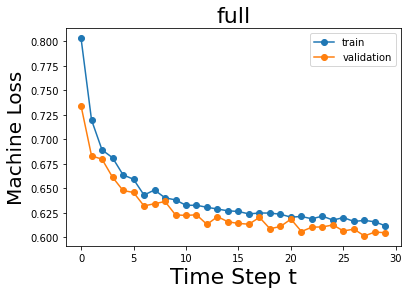

In [19]:
train_full(data_path,'full')

In [295]:
def train_g_full(data_path):
    machine_type = 'full'
    print('started training g Using machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float()
    Y = torch.from_numpy(data['Y']).long()
    hloss = data['hloss']
    
    with torch.no_grad():
        mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

        mnet.load_state_dict(torch.load(model_dir + 'm_full'))

        mnet.to(device)
        mnet.eval()
    
    
    val_X = torch.from_numpy(data['val']['X']).float()
    val_Y = torch.from_numpy(data['val']['Y']).long()
    val_hloss = data['val']['hloss']
    
    batch_size = 128
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0] / batch_size)
    
    num_epochs = 30
    
    gnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)
    gnet.to(device)
    g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.001)
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 8
    patience = 0
    eps = 1e-3
    
    for epoch in range(num_epochs):
        gprediction = []
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
            Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size].to(device)
            with torch.no_grad():
                machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
                machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint=1.0)
            g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
            g_optimizer.zero_grad()
            gpred = gnet(X_batch)
            gprediction.extend(gpred[:,1])
            g_loss = loss_func(gpred,g_labels)
            g_loss.sum().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())

            
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
        
        with torch.no_grad():
            val_gloss = 0
            for i in range(val_num_batches):
                val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
                val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
                val_hloss_batch = val_hloss[i * batch_size: (i + 1) * batch_size].to(device)
                val_machine_loss = loss_func(mnet(val_X_batch),val_Y_batch)
                val_machine_indices = find_machine_samples(val_machine_loss,val_hloss_batch,constraint=1.0)
                val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X_batch.shape[0])]).to(device)
                val_loss = loss_func(gnet(val_X_batch),val_glabels)
                val_gloss += float(val_loss.mean())

                
            val_gloss /= val_num_batches
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))

            if val_gloss + eps < best_val_loss:
                torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type)
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
            else:
                patience += 1

        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
                
        print('\n')
        
    del gnet
    del mnet
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g' ,fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()

started training g Using machine model:  full
----- epoch: 0 -----
g_loss: 0.672992653834323
val_g_loss: 0.5888034729287028
updated the model


----- epoch: 1 -----
g_loss: 0.5574305523186922
val_g_loss: 0.5489661861211061
updated the model


----- epoch: 2 -----
g_loss: 0.5313154670099417
val_g_loss: 0.5423036413267255
updated the model


----- epoch: 3 -----
g_loss: 0.5185243698457876
val_g_loss: 0.5380338532850146
updated the model


----- epoch: 4 -----
g_loss: 0.5145377491911253
val_g_loss: 0.5337892817333341
updated the model


----- epoch: 5 -----
g_loss: 0.5156425855432948
val_g_loss: 0.5269233109429479
updated the model


----- epoch: 6 -----
g_loss: 0.5085851553206643
val_g_loss: 0.5292033655568957


----- epoch: 7 -----
g_loss: 0.5099590004732212
val_g_loss: 0.5309763262048364


----- epoch: 8 -----
g_loss: 0.5089500034227967
val_g_loss: 0.5307842837646604


----- epoch: 9 -----
g_loss: 0.5065685976296663
val_g_loss: 0.5388612626120448


----- epoch: 10 -----
g_loss: 0.50937

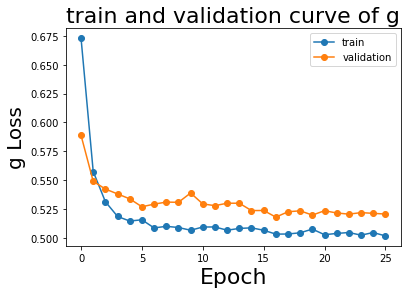

In [296]:
train_g_full(data_path)

In [97]:
def get_test_assignments_full(constraints):
    with torch.no_grad():
        machine_type = 'full'
        threshold_map = {0.0:0.0,0.2:0.30,0.4:0.30,0.6:0.30,0.8:0.21,1.0:0.37}
        loss_func = torch.nn.NLLLoss(reduction='none')
        data = load_data(data_path)
        test_X = torch.from_numpy(data['test']['X']).float().to(device)
        test_Y = data['test']['Y']
        hlabel = data['test']['hpred']
        hcrossloss = data['test']['hloss']

        mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
        mnet.to(device)
        mnet.load_state_dict(torch.load(model_dir + 'm_full'))
        mnet.eval()
        mscores = mnet(test_X)
        mcrossloss=loss_func(mscores,torch.tensor(test_Y).to(device))
        mlabel = torch.argmax(mscores,dim=1).cpu().data.numpy()

        gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)
        gnet.to(device)
        gnet.load_state_dict(torch.load(model_dir + 'g_full'))
        gnet.eval()
        gprediction = torch.exp(gnet(test_X).detach()[:,1])
        
        
        argsorted_g = torch.argsort(gprediction)
        

        losses = []
        for constraint in constraints:
            if constraint==0.0:
                losses.append(data['Differentiable']['agg_loss'][0])
                continue
                
            num_machine = int((1.0 - constraint) * test_X.shape[0])
            loss = np.zeros(test_X.shape[0])

            human_candidates = torch.argsort(gprediction)[num_machine:]
            to_machine = [i for i in range(mlabel.shape[0]) if i not in human_candidates or gprediction[i]<threshold_map[constraint]]
            to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
            
            mloss = np.not_equal(mlabel,test_Y)
            hloss = np.not_equal(hlabel,test_Y)
            print(len(to_machine),len(to_human))
            if len(to_machine)!=0:
                loss[to_machine] = mloss[to_machine]
                print('mean of machine error:' ,np.mean(loss[to_machine]))
            if to_human.shape[0]!=0:
                loss[to_human] = hloss[to_human]
                print('mean of human error:' ,np.mean(loss[to_human]))
                
            losses.append(np.mean(loss))
                

    plt.plot(constraints,losses,marker='o')
    plt.title(r'Full Automaion Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    
    if machine_type not in data:
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


3280 820
mean of machine error: 0.17134146341463416
mean of human error: 0.09268292682926829
2460 1640
mean of machine error: 0.1540650406504065
mean of human error: 0.09817073170731708
1640 2460
mean of machine error: 0.1420731707317073
mean of human error: 0.0991869918699187
819 3281
mean of machine error: 0.12454212454212454
mean of human error: 0.10057909174032308
0 4100
mean of human error: 0.09926829268292683


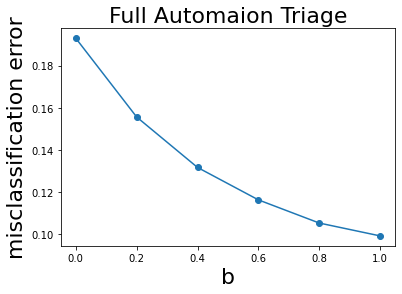

In [98]:
get_test_assignments_full(constraints)

## [Score-based Triage](https://arxiv.org/abs/1903.12220)

-----training machine model:  score
----- epoch: 0 -----
machine_loss: 0.8883939047033588
val_loss: 0.6963739991188049
updated the model


----- epoch: 1 -----
machine_loss: 0.740089539748927
val_loss: 0.7698062062263489


----- epoch: 2 -----
machine_loss: 0.6773063031335672
val_loss: 0.6558063626289368
updated the model


----- epoch: 3 -----
machine_loss: 0.6597539105763038
val_loss: 0.6180089116096497
updated the model


----- epoch: 4 -----
machine_loss: 0.6282576915497581
val_loss: 0.6114369034767151
updated the model


----- epoch: 5 -----
machine_loss: 0.6257897856024405
val_loss: 0.6125285029411316


----- epoch: 6 -----
machine_loss: 0.6193565751115481
val_loss: 0.6292545199394226


----- epoch: 7 -----
machine_loss: 0.617627662451317
val_loss: 0.6117973327636719


----- epoch: 8 -----
machine_loss: 0.6117257429286838
val_loss: 0.6221941709518433


----- epoch: 9 -----
machine_loss: 0.6150570386089385
val_loss: 0.6168136596679688


----- epoch: 10 -----
machine_loss: 0.613275

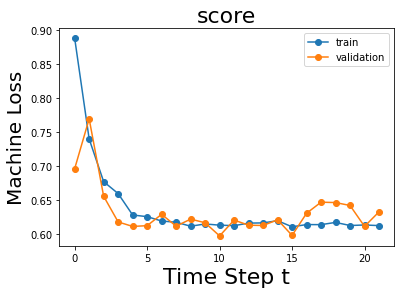

In [292]:
train_full(data_path,'score')

In [102]:
def get_assignments_score(data_path,constraints):
    machine_type = 'score'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_score'))
    mnet.eval()
    mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
    loss = np.zeros(test_X.shape[0])
    mconf,_ = torch.max(mnet(test_X),axis = 1)
    
    losses = []
    for constraint in constraints:
        if constraint==0.0:
                losses.append(data['Differentiable']['agg_loss'][0])
                continue
        num_machine = int((1.0-constraint) * test_X.shape[0])
        to_machine = torch.argsort(mconf,descending = True)[:num_machine].cpu().data.numpy()
        to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        if len(to_machine)!=0:
            loss[to_machine] = mloss[to_machine]
        if to_human.shape[0]!=0:
            loss[to_human] =  hloss[to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Score-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.show()
    if machine_type not in data.keys():
        data[machine_type] = {}
        
    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


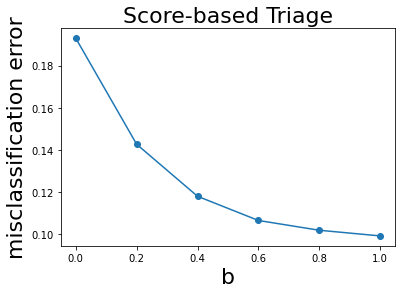

In [103]:
get_assignments_score(data_path,constraints)

## [Surrogate-based Triage](https://arxiv.org/abs/2006.01862)
The code is taken from [here](https://github.com/clinicalml/learn-to-defer) where the authors provide implementation of their method.

In [119]:
def surrogate_train(data_path):

    def loss_func(outputs, m, labels, m2, n_classes):
        '''
        The L_{CE} loss implementation for hatespeech, identical to CIFAR implementation
        ----
        outputs: network outputs
        m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        labels: target
        m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
        '''
        batch_size = outputs.shape[0] # batch_size
        rc = [n_classes] * batch_size

        rc = torch.tensor(rc)

        outputs = -m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log2(outputs[range(batch_size), labels])  # pick the values corresponding to the labels
        return torch.sum(outputs)/batch_size
    
    print('-----training machine model : surrogate')
    machine_type = 'surrogate'
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).to(device).long()
    human_is_correct = torch.from_numpy(np.array([1 if data['hpred'][i]==data['Y'][i] else 0
                                                  for i in range(X.shape[0])])).to(device)
    alpha = 1.0
    m = (human_is_correct) * 1.0
    m2 = [1.0] * X.shape[0]
    m2 = torch.tensor(m2)
    for j in range(0, X.shape[0]):
        exp = m[j].item()
        if exp:
            m2[j] = alpha
        else:
            m2[j] = 1
    m2 = m2.to(device)


    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).to(device).long()
    val_human_is_correct = torch.from_numpy(np.array([1 if data['val']['hpred'][i] == data['val']['Y'][i] else 0
                                                      for i in range(val_X.shape[0])])).to(device)
    val_m = (val_human_is_correct) * 1.0
    val_m2 = [1.0] * val_X.shape[0]
    val_m2 = torch.tensor(val_m2)
    for j in range(0, val_X.shape[0]):
        exp = val_m[j].item()
        if exp:
            val_m2[j] = alpha
        else:
            val_m2[j] = 1
    val_m2 = val_m2.to(device)
    
    batch_size = 64
    num_epochs = 30

    num_batches = int(X.shape[0] / batch_size)
    
    N_FILTERS = 300  # hyperparameterr
    FILTER_SIZES = [3, 4, 5]
    DROPOUT = 0.5
    output_dim = 3
    mnet = CNN_rej(embedding_dim = 100,vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(mnet.parameters())
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4

    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        epoch_loss = 0
        val_epoch_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y[i * batch_size:(i + 1) * batch_size]
            m_batch = m[i * batch_size:(i + 1) * batch_size]
            m2_batch = m2[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),m_batch,Y_batch,m2_batch,output_dim)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)


        print('train loss: ',epoch_loss/ num_batches)
        train_losses.append(epoch_loss / num_batches)
        with torch.no_grad():
            m_val_prob = mnet(val_X)
            val_loss = loss_func(m_val_prob, val_m, val_Y, val_m2, output_dim)
            val_losses.append(float(val_loss))
            print('validation loss: ', float(val_loss))
            
            if val_loss < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_surrogate')
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
            if patience > max_patience:
                print('no progress for 10 epochs... stopping training')
                break
    
        print('\n')
            
    plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    plt.plot(range(len(val_losses)),val_losses,marker='o', label = 'validation')
    plt.legend()
    plt.title(machine_type,fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.legend()
    plt.show()

-----training machine model : surrogate
----- epoch: 0 -----
train loss:  3.2142754631737867
validation loss:  2.9810407161712646
updated the model


----- epoch: 1 -----
train loss:  2.9643042410413423
validation loss:  2.8970794677734375
updated the model


----- epoch: 2 -----
train loss:  2.8988651844362416
validation loss:  2.867955207824707
updated the model


----- epoch: 3 -----
train loss:  2.8655267506837845
validation loss:  2.8580102920532227
updated the model


----- epoch: 4 -----
train loss:  2.8540688616534076
validation loss:  2.8203330039978027
updated the model


----- epoch: 5 -----
train loss:  2.857344675809145
validation loss:  2.828455686569214


----- epoch: 6 -----
train loss:  2.8433474972844124
validation loss:  2.8320417404174805


----- epoch: 7 -----
train loss:  2.8423988496263823
validation loss:  2.823479175567627


----- epoch: 8 -----
train loss:  2.8342278860509396
validation loss:  2.8232154846191406


----- epoch: 9 -----
train loss:  2.8231961640

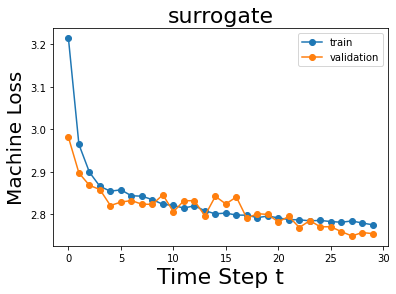

In [120]:
surrogate_train(data_path)

In [12]:
def get_test_assignments_surrogate(data_path,constraints):
    machine_type = 'surrogate'
    loss_func = torch.nn.NLLLoss(reduction='none')
    data = load_data(data_path)
    test_X = torch.from_numpy(data['test']['X']).float().to(device)
    test_Y = data['test']['Y']
    hlabel = data['test']['hpred']
    
    mnet = CNN_rej(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    mnet.load_state_dict(torch.load(model_dir + 'm_surrogate'))
    mnet.eval()
    mscores = mnet(test_X)
    assert(mscores.shape[1]==4)
    mlabel = torch.argmax(mscores[:,:-1],dim=1).cpu().data.numpy()
    assert (mlabel<4).all()
    loss = np.zeros(test_X.shape[0])
    last_class_prob = mscores[:,-1]
    highest_prob,_ = torch.max(mscores[:,:-1],dim=1)
    diff = last_class_prob - highest_prob
    
    losses = []
    for constraint in constraints:
        num_machine = int((1.0-constraint) * test_X.shape[0])
        
        to_human = torch.argsort(diff)[num_machine:].cpu().data.numpy()
        final_to_human = []
        for th in to_human:
            if diff[th]>0:
                final_to_human.append(th)

        
        
        to_machine = np.array([i for i in range(test_X.shape[0]) if i not in final_to_human])
        
        mloss = np.not_equal(mlabel,test_Y)
        hloss = np.not_equal(hlabel,test_Y)

        loss[to_machine] = mloss[to_machine]
        loss[final_to_human] =  hloss[final_to_human]

        losses.append(np.mean(loss))
        
    plt.plot(constraints,losses,marker='o')
    plt.title(r'Surrogate-based Triage',fontsize=22)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    
    if machine_type not in data.keys():
        data[machine_type] = {}

    data[machine_type]['agg_loss'] = losses
    save_data(data,data_path)


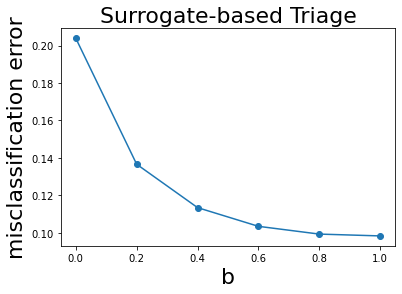

In [14]:
get_test_assignments_surrogate(data_path,constraints)

In [75]:
def plot_misclassification_loss(data_path,machine_types):
    data = load_data(data_path)
    for machine_type in machine_types:
        agg_loss = data[machine_type]['agg_loss']
        plt.plot(constraints,agg_loss,marker='o',label=machine_type)
    plt.xticks(constraints)
    plt.ylabel(r'misclassification error',fontsize=22)
    plt.xlabel(r'b',fontsize=22)
    plt.legend()

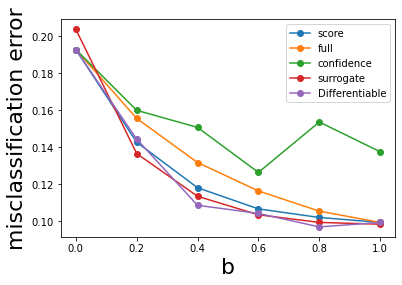

In [123]:
machine_types =  ['score','full','confidence','surrogate','Differentiable']
plot_misclassification_loss(data_path,machine_types)